### Introduction

This project uses unsupervised learning to explore crime rates and urbanization patterns across U.S. states in 1973. Through Principal Component Analysis and clustering, we reveal hidden relationships between types of crime and urban density, offering insight into regional trends and data-driven groupings.

The project focuses on two key goals:
- **Dimensionality reduction using Principal Component Analysis**(PCA) to identify underlying structures in the crime data.
- **Clustering analysis** to group states with similar crime and urbanization profiles.

By analyzing and visualizing this dataset, we aim to uncover latent relationships between different types of crime and the degree of urban density. The insights generated will not only deepen our understanding of criminal trends in a historical context but also showcase the power of unsupervised learning for exploratory analysis.



#### Set-Up The Dataset

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

#### Load The Dataset
Load the dataset using the `pandas` library for python

In [2]:
# Load the dataset
df = pd.read_csv('UsArrests.csv')

df.set_index('City', inplace=True)  # Set state names as index

# Show the first few rows of the dataset
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


#### Explore The Data
Exploring the structure, checking for missing values, data types, and summary statistics.

In [3]:
# Check for missing values
df.isnull().sum()
# Display the dataset information
df.info()
# Display the dataset statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


### Data Preprocessing
To prepare the data for PCA and clustering, we standardize the features using `StandardScaler`. This ensures that all variables contribute equally to the analysis.

In [4]:
# standardize the data for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

#### Correlation Analysis
We compute and visualize the correlation matrix to understand relationships between crime types and urban population. This helps inform our PCA interpretation.

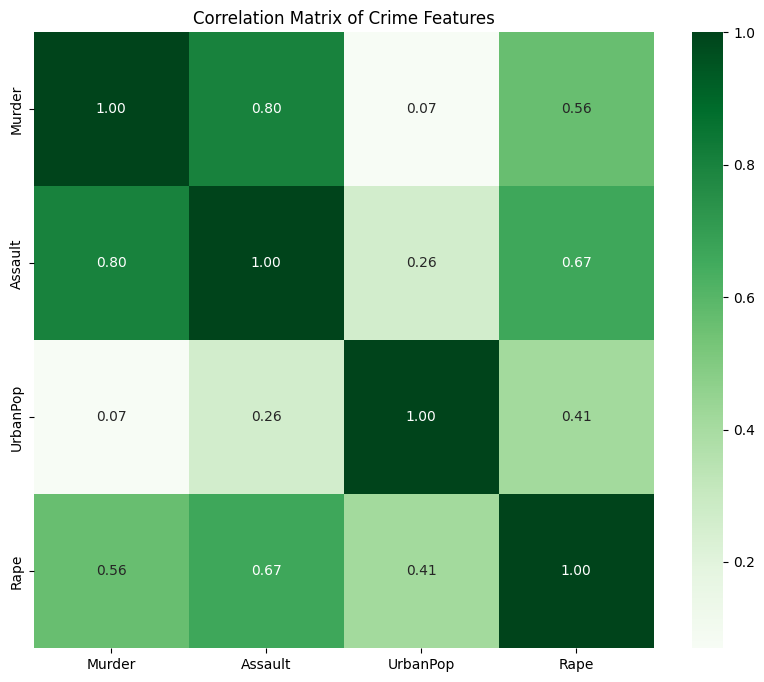

In [5]:
# Drop non-numeric columns (like state names) before correlation
numeric_df = df.select_dtypes(include=[np.number])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='Greens', fmt='.2f')
plt.title('Correlation Matrix of Crime Features')
plt.show()


##### Insight:
- **Murder vs Assault** (↑ ~0.80): Strong positive correlation — states with higher murder rates tend to also have high assault rates.
- **Rape vs UrbanPop** (↑ ~0.43): Moderate positive correlation — rape rates seem somewhat associated with higher urbanization.
- **Assault vs UrbanPop** (↑ ~0.26): Weak positive relationship — denser states might see slightly elevated assault figures.
- **Murder vs UrbanPop** (↑ ~0.07): Very weak or negligible relationship — murder doesn’t appear driven by urbanization levels.
- **Rape vs Murder** (↑ ~0.56): Moderate positive correlation — states with higher murder rates may also report higher rape rates.

These patterns help guide feature selection and dimensionality reduction in PCA.


#### Principal Component Analysis

In [6]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)


#### Explained Variance
We display the proportion of variance explained by each principal component, rounded to four decimal places. This helps determine how many components to retain for clustering.

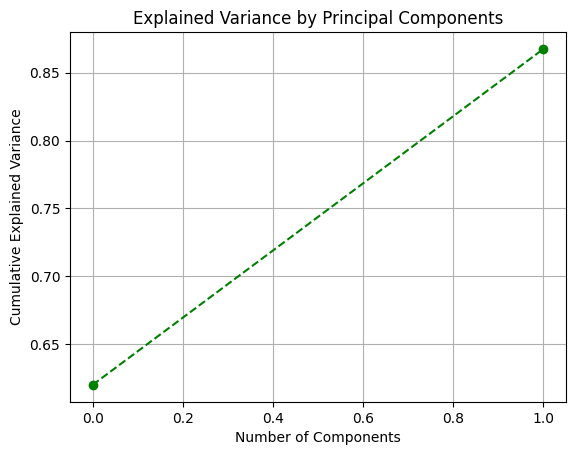

Explained variance by components: ['0.6201', '0.2474']


In [7]:
# Explained variance plot (scree plot)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 
         marker='o', 
         linestyle='--',
         color='green'
         )
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Explained variance
explained_var = pca.explained_variance_ratio_
formatted_var = [f"{var:.4}" for var in explained_var]
print("Explained variance by components:", formatted_var)


#### Biplot of PC1 vs PC2
The biplot shows how each original feature contributes to the first two principal components. This aids in interpreting the PCA results.

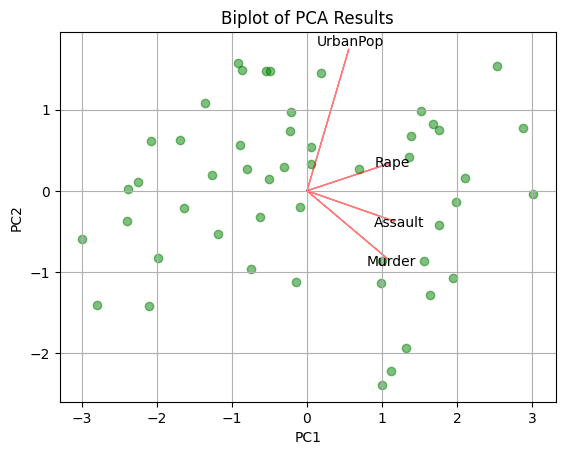

In [8]:
# Biplot of PC1 vs PC2 function
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    plt.scatter(xs, ys, color='green', alpha=0.5)
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i,0]*2, coeff[i,1]*2,
                  color='red', alpha=0.5)
        plt.text(coeff[i,0]*2.1, coeff[i,1]*2.1,
                 labels[i], color='black', ha='center', va='center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

# Call the biplot function
biplot(pca_result, pca.components_.T, labels=numeric_df.columns)
plt.title('Biplot of PCA Results')
plt.show()

### Selection of Principal Components

I selected **2 principal components** for further analysis. This choice is based on the cumulative explained variance, where the first two components capture over 85% of the total variance in the dataset. This ensures that most of the information is retained while reducing dimensionality for clustering and visualization. Additionally, using two components allows for intuitive 2D plots and simplifies interpretation of the results.


#### K-Means Clustering
We apply K-Means clustering to the PCA-transformed data. We assign cluster labels and analyze the characteristics of each cluster.

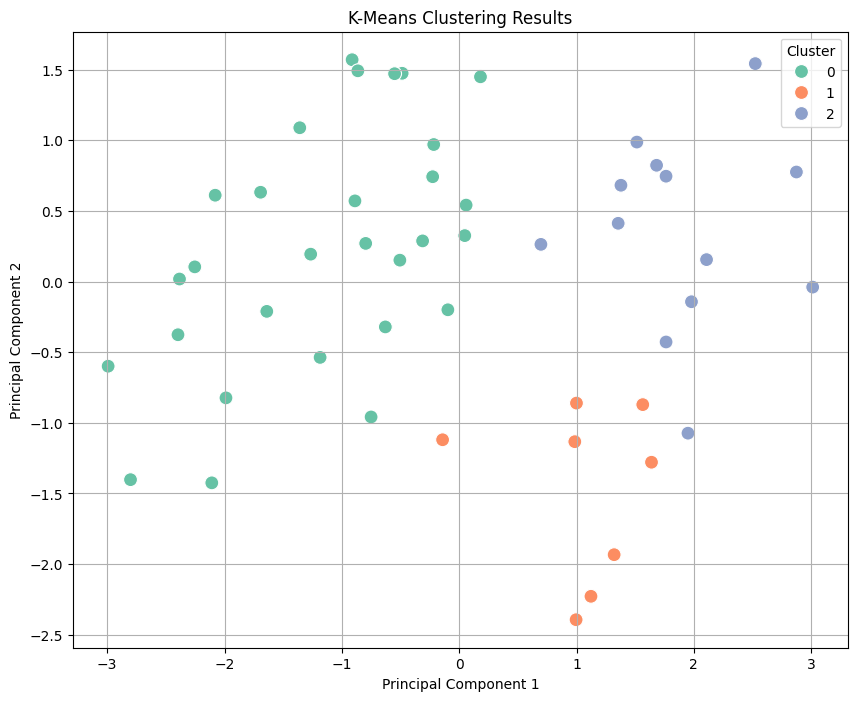

In [9]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)
df['Cluster'] = kmeans.labels_

# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0],
                y=pca_result[:, 1], 
                hue=df['Cluster'], 
                palette='Set2', 
                s=100
)
plt.title('K-Means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### Hierarchical Clustering
We use hierarchical clustering and generate a dendrogram to visualize how states group based on crime and urban population patterns.

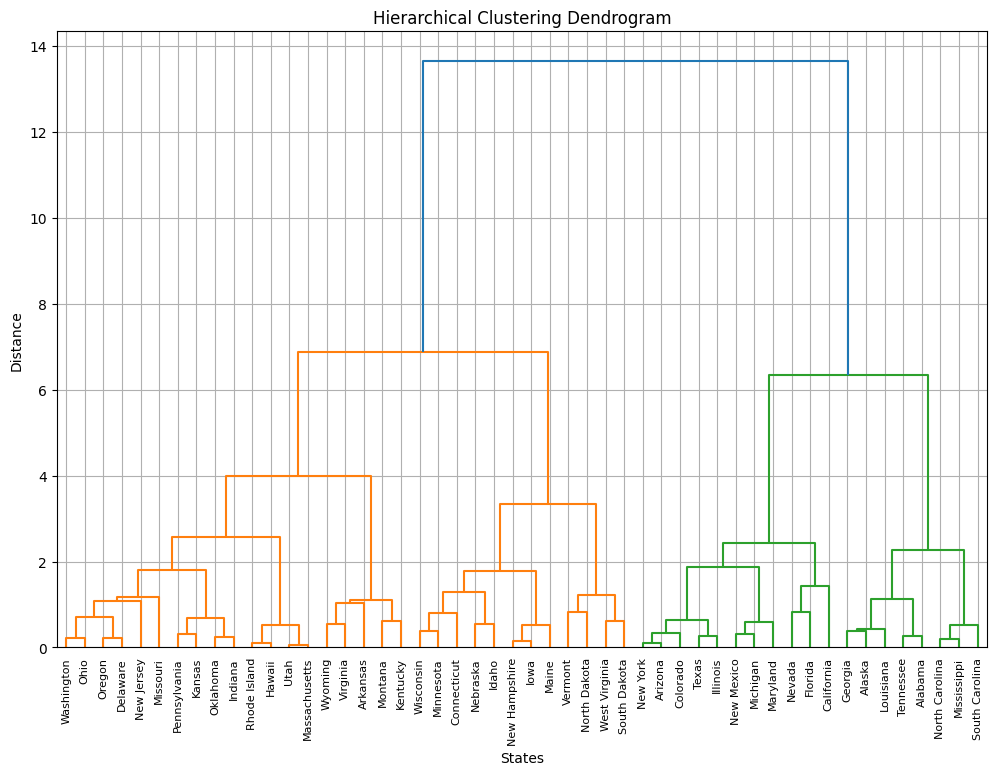

In [10]:
# Hierarchical Clustering
linked = linkage(pca_result, method='ward')

# Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked,
            orientation='top',
            labels=df.index,
            distance_sort='descending',
            show_leaf_counts=True
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('States')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

#### Cluster Analysis
We compare the clusters generated by both methods and interpret similarities among states within each cluster.

In [12]:
# Cluster Analysis
silhouette_avg = silhouette_score(scaled_data, df['Cluster'])
print(f'Silhouette Score for K-Means Clustering: {silhouette_avg:.4f}')
# Display the mean values of each cluster
print(df.groupby('Cluster').mean())

Silhouette Score for K-Means Clustering: 0.3668
            Murder     Assault   UrbanPop       Rape
Cluster                                             
0         4.734483  111.827586  64.103448  15.820690
1        13.937500  243.625000  53.750000  21.412500
2        10.815385  257.384615  76.000000  33.192308


#### Conclusion
Through the application of Principal Component Analysis (PCA) and K-Means clustering on the US Arrests dataset, we uncovered meaningful patterns in crime rates and urbanization across the 50 states in 1973. PCA effectively reduced the dataset’s dimensionality while preserving the most significant variance, allowing us to visualize and interpret the data more clearly.

The clustering analysis revealed distinct groupings of states based on their crime profiles and urban density. Each cluster exhibited unique characteristics—some dominated by high assault and rape rates, others by low crime and rural demographics. These insights demonstrate how unsupervised learning can uncover hidden structures in data without predefined labels.

Ultimately, this project highlights the power of combining PCA with clustering to explore complex datasets, offering a foundation for deeper sociological or policy-driven investigations.